In [846]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
from scipy.stats import mstats
from optbinning import OptimalBinning
from sklearn.model_selection import GridSearchCV
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import mstats


# Import các function hỗ trợ
from Func import WOE_transform, calc_iv, convert_dummy, get_category, plot_confusion_matrix, Winsorize_Feature, WOE_transform

I. Load data

application_record.csv contains independent variables with 438557 records:
* CATEGORICAL FEATURES:
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_OWN_REALTY
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- OCCUPATION_TYPE

* NUMERICAL FEATURES:
- CNT_CHILDREN
- AMT_INCOME_TOTAL
- DAYS_BIRTH
- DAYS_EMPLOYED
- FLAG_MOBIL
- FLAG_WORK_PHONE
- FLAG_PHONE
- FLAG_EMAIL
- CNT_FAM_MEMBERS

In [697]:
application = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\CRProject\\Data\\application_record.csv')

application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [698]:
#Check duplicate for application_record.csv
duplicates = application[application.duplicated()]
print('Duplicated rows:')
duplicates

Duplicated rows:


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS


credit_record.csv contains target variable of model:
- ID: Indetifier for individuals or entities
- MONTHS_BALANCE: Number of months before the current month. For example, 0 woule represent the current month, -1 would represent the previous month, -2 the month before that, and so on
- STATUS: Credit status or rating for the associated ID at a specific month. The status represents using codes like "X", "C" or numeric values. "X" for no DPD, "C" for closed or paid that month, and numeric values for the number of loan group (1,2,3,4,5)

In [699]:
credit = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\CRProject\\Data\\credit_record.csv')

credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


II. Data preprocessing

2.1.credit_record.csv (Target_variable)

In [700]:
#Encode loan group
loan_group = credit.copy()

#Chuyển các status X và C thành 0
loan_group['STATUS']=loan_group['STATUS'].apply(lambda x: 0 if (x=='X'or x=='C') else x)
loan_group['STATUS']=loan_group['STATUS'].astype(int)

#Lấy max nhóm STATUS chính là nhóm nợ 
loan_group = loan_group.groupby(['ID']).aggregate({'MONTHS_BALANCE': 'count', 'STATUS':'max'})
loan_group.head()

,MONTHS_BALANCE,STATUS
ID,,
5001711,4,0
5001712,19,0
5001713,22,0
5001714,15,0
5001715,60,0


In [701]:
#Default flag
loan_group['df_flag']= loan_group['STATUS'].apply(lambda x: 1 if x>=3 else 0)

loan_group['df_flag']=loan_group['df_flag'].astype(int)
loan_group[loan_group['STATUS']>=3].head()

,MONTHS_BALANCE,STATUS,df_flag
ID,,,
5002126,56,3,1
5003267,54,3,1
5003471,48,4,1
5003712,38,3,1
5003804,55,5,1


2.2.Merge application_record with loan_group

In [702]:
merge_data = pd.merge(application, loan_group, how="left", right_on='ID', left_on='ID')
merge_data.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,df_flag
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,16.0,1.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,15.0,1.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,30.0,0.0,0.0


In [703]:
#Check những trường hợp không match được thông tin df_flag
merge_data[merge_data['df_flag'].isna()].shape
#Đây là những trường hợp không có thông tin credit_record => Loại bỏ khỏi tập dữ liệu

(402100, 21)

In [704]:
#Loại bỏ những trường hợp không lấy được thông tin df_flag
data = merge_data[~merge_data['df_flag'].isna()]
data.shape

(36457, 21)

2.3. application_record.csv

In [705]:
#Rename columns trong dataset
data.rename(columns = 
                {'CODE_GENDER': 'gender', 
                'FLAG_OWN_CAR': 'car',
                'FLAG_OWN_REALTY': 'reality',
                'CNT_CHILDREN': 'chldNo',
                'AMT_INCOME_TOTAL': 'inc',
                'NAME_EDUCATION_TYPE': 'edutp',
                'NAME_FAMILY_STATUS': 'famtp',
                'NAME_HOUSING_TYPE': 'houtp',
                'FLAG_EMAIL': 'email',
                'NAME_INCOME_TYPE': 'inctp',
                'FLAG_WORK_PHONE': 'wkphone',
                'FLAG_PHONE': 'phone',
                'CNT_FAM_MEMBERS': 'famsize',
                'OCCUPATION_TYPE': 'occtp',
                'FLAG_MOBIL':'mobile',
                'DAYS_BIRTH': 'birthDt',
                'DAYS_EMPLOYED': 'empDt'
                }, inplace=True)

data.columns

Index(['ID', 'gender', 'car', 'reality', 'chldNo', 'inc', 'inctp', 'edutp',
       'famtp', 'houtp', 'birthDt', 'empDt', 'mobile', 'wkphone', 'phone',
       'email', 'occtp', 'famsize', 'MONTHS_BALANCE', 'STATUS', 'df_flag'],
      dtype='object')

In [706]:
#Tính toán working time
data['wkTime'] = np.round(np.subtract(data['empDt'], data['birthDt'])/365,0)
data.head(2)

,ID,gender,car,reality,chldNo,inc,inctp,edutp,famtp,houtp,...,mobile,wkphone,phone,email,occtp,famsize,MONTHS_BALANCE,STATUS,df_flag,wkTime
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,16.0,1.0,0.0,20.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,15.0,1.0,0.0,20.0


In [707]:
#Drop irrelevant columns
data = data.drop(columns=['MONTHS_BALANCE', 'STATUS', 'birthDt', 'empDt'])

In [708]:
categorical_lst = ['gender', 'car', 'reality', 'inctp', 'edutp', 'famtp', 'houtp', 'occtp', 'mobile', 'wkphone', 'phone','email']
numerical_lst = ['chldNo', 'inc', 'famsize','wkTime']

III. EDA

3.1. Kiểm tra missing và tính toán IV cho categorical variable:
- gender
- car
- reality
- inctp
- edutp
- famtp
- houtp
- occtp

In [709]:
#Tạo bảng lưu thông tin IV
ivtable_categorical = pd.DataFrame(categorical_lst , columns = ['variable'])
ivtable_categorical['IV'] = None

ivtable_categorical

,variable,IV
0,gender,None
1,car,None
2,reality,None
3,inctp,None
4,edutp,None
5,famtp,None
6,houtp,None
7,occtp,None
8,mobile,None
9,wkphone,None


gender

In [710]:
#Kiểm tra giá trị missing cho biến gender
data['gender'].isna().sum()

0

In [711]:
iv, iv_gender = calc_iv(data, 'gender', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='gender','IV'] = iv
iv_gender

This variable IV is:  0.013039944644721704
F    24430
M    12027
Name: gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,gender,F,24430,24244,186,0.670105,0.007614,0.670557,0.615894,0.085034,0.004648
1,gender,M,12027,11911,116,0.329895,0.009645,0.329443,0.384106,-0.153516,0.008392


car

In [712]:
#Kiểm tra giá trị missing cho biến car
data['car'].isna().sum()

0

In [713]:
iv, iv_car = calc_iv(data, 'car', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='car','IV'] = iv
iv_car

This variable IV is:  0.002824891289979709
N    22614
Y    13843
Name: car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,car,N,22614,22419,195,0.620292,0.008623,0.62008,0.645695,-0.040479,0.001037
1,car,Y,13843,13736,107,0.379708,0.007730,0.37992,0.354305,0.069803,0.001788


reality

In [714]:
#Kiểm tra giá trị missing
data['reality'].isna().sum()

0

In [715]:
iv, iv_reality = calc_iv(data, 'reality', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='reality','IV'] = iv
iv_reality

This variable IV is:  0.02550150105179187
Y    24506
N    11951
Name: reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,reality,N,11951,11829,122,0.327811,0.010208,0.327175,0.403974,-0.210855,0.016193
1,reality,Y,24506,24326,180,0.672189,0.007345,0.672825,0.596026,0.121201,0.009308


inctp

In [716]:
#Kiểm tra giá trị missing
data['inctp'].isna().sum()

0

In [717]:
iv, iv_inctp = calc_iv(data, 'inctp', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='inctp','IV'] = iv
iv_inctp

This variable IV is:  0.05168464073183815
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,inctp,Commercial associate,8490,8407,83,0.232877,0.009776,0.232527,0.274834,-0.167164,0.007072
1,inctp,Pensioner,6152,6081,71,0.168747,0.011541,0.168193,0.235099,-0.334899,0.022407
2,inctp,State servant,2985,2966,19,0.081877,0.006365,0.082036,0.062914,0.265387,0.005075
3,inctp,Student,11,11,0,0.000302,0.000000,0.000304,0.000000,0.000000,0.000000
4,inctp,Working,18819,18690,129,0.516197,0.006855,0.516941,0.427152,0.190788,0.017131


edutp	

In [718]:
#Kiểm tra giá trị missing
data['edutp'].isna().sum()

0

In [719]:
iv, iv_edutp = calc_iv(data, 'edutp', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='edutp','IV'] = iv
iv_edutp

This variable IV is:  0.03704630899309003
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,edutp,Academic degree,32,32,0,0.000878,0.000000,0.000885,0.000000,0.000000,0.000000
1,edutp,Higher education,9864,9773,91,0.270565,0.009225,0.270308,0.301325,-0.108624,0.003369
2,edutp,Incomplete higher,1410,1390,20,0.038676,0.014184,0.038446,0.066225,-0.543817,0.015107
3,edutp,Lower secondary,374,367,7,0.010259,0.018717,0.010151,0.023179,-0.825692,0.010757
4,edutp,Secondary / secondary special,24777,24593,184,0.679623,0.007426,0.680210,0.609272,0.110138,0.007813


famtp

In [720]:
#Kiểm tra giá trị missing
data['famtp'].isna().sum()

0

In [721]:
iv, iv_famtp = calc_iv(data, 'famtp', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='famtp','IV'] = iv
iv_famtp

This variable IV is:  0.09226285116928862
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,famtp,Civil marriage,2945,2937,8,0.080780,0.002716,0.081234,0.026490,1.120559,0.061343
1,famtp,Married,25048,24850,198,0.687056,0.007905,0.687318,0.655629,0.047202,0.001496
2,famtp,Separated,2103,2076,27,0.057684,0.012839,0.057419,0.089404,-0.442782,0.014162
3,famtp,Single / not married,4829,4778,51,0.132457,0.010561,0.132153,0.168874,-0.245192,0.009004
4,famtp,Widow,1532,1514,18,0.042022,0.011749,0.041875,0.059603,-0.353005,0.006258


houtp

In [722]:
#Kiểm tra giá trị missing
data['houtp'].isna().sum()

0

In [723]:
iv, iv_houtp = calc_iv(data, 'houtp', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='houtp','IV'] = iv
iv_houtp

This variable IV is:  0.05957405876520091
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,houtp,Co-op apartment,168,165,3,0.004608,0.017857,0.004564,0.009934,-0.777810,0.004177
1,houtp,House / apartment,32548,32288,260,0.892778,0.007988,0.893044,0.860927,0.036626,0.001176
2,houtp,Municipal apartment,1128,1106,22,0.030941,0.019504,0.030591,0.072848,-0.867681,0.036666
3,houtp,Office apartment,262,258,4,0.007187,0.015267,0.007136,0.013245,-0.618478,0.003778
4,houtp,Rented apartment,575,570,5,0.015772,0.008696,0.015765,0.016556,-0.048945,0.000039
5,houtp,With parents,1776,1768,8,0.048715,0.004505,0.048901,0.026490,0.613019,0.013738


occtp

In [724]:
#Kiểm tra giá trị missing
data['occtp'].isna().sum()

11323

In [725]:
data.loc[data['occtp']=='NULL', 'occtp'] = 'Nojob'
data['occtp'].value_counts()


Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: occtp, dtype: int64

In [726]:
iv, iv_occtp = calc_iv(data, 'occtp', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='occtp','IV'] = iv
iv_occtp

This variable IV is:  0.08232465758944826
NULL                     11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: occtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,occtp,Accountants,1241,1234,7,0.034040,0.005641,0.034131,0.023179,0.386963,0.004238
1,occtp,Cleaning staff,551,548,3,0.015114,0.005445,0.015157,0.009934,0.422519,0.002207
2,occtp,Cooking staff,655,650,5,0.017966,0.007634,0.017978,0.016556,0.082391,0.000117
3,occtp,Core staff,3591,3542,49,0.098500,0.013645,0.097967,0.162252,-0.504517,0.032433
4,occtp,Drivers,2138,2123,15,0.058644,0.007016,0.058719,0.049669,0.167392,0.001515
5,occtp,HR staff,85,85,0,0.002332,0.000000,0.002351,0.000000,0.000000,0.000000
6,occtp,High skill tech staff,1383,1370,13,0.037935,0.009400,0.037892,0.043046,-0.127527,0.000657
7,occtp,IT staff,60,58,2,0.001646,0.033333,0.001604,0.006623,-1.417848,0.007115
8,occtp,Laborers,6211,6163,48,0.170365,0.007728,0.170461,0.158940,0.069974,0.000806
9,occtp,Low-skill Laborers,175,173,2,0.004800,0.011429,0.004785,0.006623,-0.324999,0.000597


mobile

In [727]:
#Kiểm tra giá trị missing
data['mobile'].isna().sum()

0

In [728]:
iv, iv_mobile = calc_iv(data, 'mobile', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='mobile','IV'] = iv
iv_mobile

This variable IV is:  0.0
1    36457
Name: mobile, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,mobile,1,36457,36155,302,1.0,0.008284,1.0,1.0,0.0,0.0


wkphone

In [729]:
#Kiểm tra giá trị missing
data['wkphone'].isna().sum()

0

In [730]:
iv, iv_wkphone = calc_iv(data, 'wkphone', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='wkphone','IV'] = iv
iv_wkphone

This variable IV is:  0.0014903992273561468
0    28235
1     8222
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,wkphone,0,28235,28006,229,0.774474,0.008111,0.774609,0.758278,0.021309,0.000348
1,wkphone,1,8222,8149,73,0.225526,0.008879,0.225391,0.241722,-0.069952,0.001142


phone

In [731]:
#Kiểm tra giá trị missing
data['phone'].isna().sum()

0

In [732]:
iv, iv_phone = calc_iv(data, 'phone', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='phone','IV'] = iv
iv_phone

This variable IV is:  0.007412833255331314
0    25709
1    10748
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,phone,0,25709,25508,201,0.705187,0.007818,0.705518,0.665563,0.058299,0.002329
1,phone,1,10748,10647,101,0.294813,0.009397,0.294482,0.334437,-0.127231,0.005083


email

In [733]:
#Kiểm tra giá trị missing
data['email'].isna().sum()

0

In [734]:
iv, iv_email = calc_iv(data, 'email', 'df_flag')
ivtable_categorical.loc[ivtable_categorical['variable']=='email','IV'] = iv
iv_email

This variable IV is:  0.0010996296907394968
0    33186
1     3271
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,email,0,33186,32914,272,0.910278,0.008196,0.910358,0.900662,0.010708,0.000104
1,email,1,3271,3241,30,0.089722,0.009172,0.089642,0.099338,-0.102704,0.000996


In [735]:
#Bảng tổng hợp IV
ivtable_categorical

,variable,IV
0,gender,0.01304
1,car,0.002825
2,reality,0.025502
3,inctp,0.051685
4,edutp,0.037046
5,famtp,0.092263
6,houtp,0.059574
7,occtp,0.082325
8,mobile,0.0
9,wkphone,0.00149


In [736]:
#Lấy ngưỡng IV là >0.02
useful_categorical_lst= ivtable_categorical['variable'][ivtable_categorical['IV']>0.02].tolist()
useful_categorical_lst

['reality', 'inctp', 'edutp', 'famtp', 'houtp', 'occtp']

3.3. Kiểm tra giá trị missing, outlier, Bining và tính IV cho numerical features

- chldNo
- inc
- mobile
- wkphone
- phone
- email
- famsize
- wkTime

In [737]:
#Tạo bảng lưu thông tin IV
ivtable_numerical = pd.DataFrame(numerical_lst , columns = ['variable'])
ivtable_numerical['IV'] = None

ivtable_numerical

,variable,IV
0,chldNo,None
1,inc,None
2,famsize,None
3,wkTime,None


chldNo

In [738]:
#Kiểm tra giá trị missing
data['chldNo'].isna().sum()

0

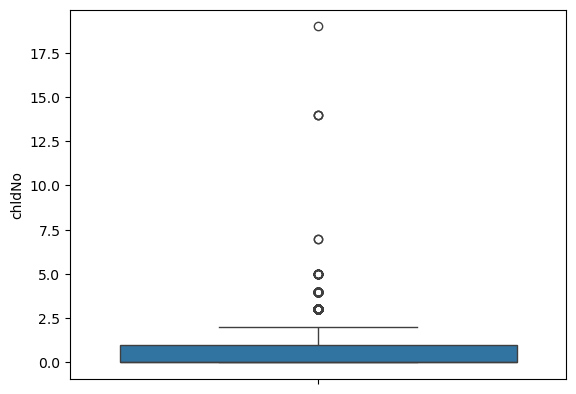

In [739]:
#Kiểm tra giá trị outlier
sns.boxplot(data['chldNo'])
plt.show()

In [740]:
# Xử lý giá trị outlier
data['chldNo'] = mstats.winsorize(data['chldNo'], limits=[0.025, 0.025])


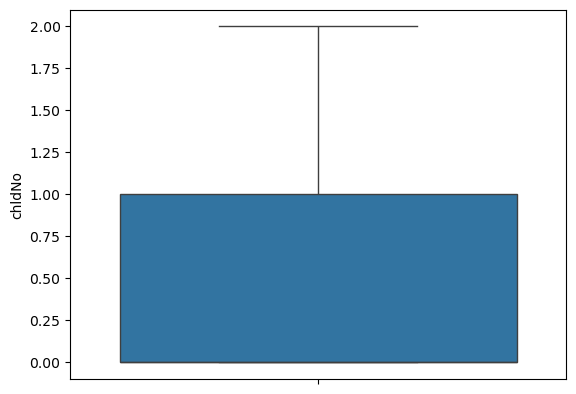

In [741]:
#Kiểm tra sau khi xử lý outlier
sns.boxplot(data['chldNo'])
plt.show()

In [742]:
#Kiểm tra sau khi xử lý outlier
data['chldNo'].value_counts()

0    25201
1     7492
2     3764
Name: chldNo, dtype: int64

In [743]:
# Tính IV
iv, iv_chldNo = calc_iv(data, 'chldNo', 'df_flag')
ivtable_numerical.loc[ivtable_numerical['variable']=='chldNo','IV'] = iv
iv_chldNo

This variable IV is:  0.002878174240527035
0    25201
1     7492
2     3764
Name: chldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,chldNo,0,25201,24986,215,0.691253,0.008531,0.691080,0.711921,-0.029711,0.000619
1,chldNo,1,7492,7432,60,0.205502,0.008009,0.205559,0.198675,0.034062,0.000234
2,chldNo,2,3764,3737,27,0.103245,0.007173,0.103361,0.089404,0.145058,0.002025


inc

In [744]:
#Kiểm tra missing
data['inc'].isna().sum()

0

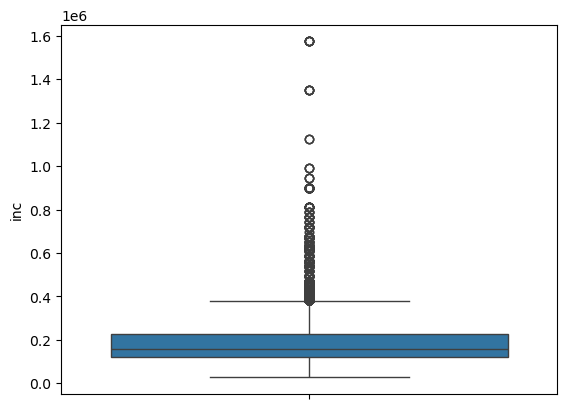

In [745]:
#Kiểm tra giá trị outlier
sns.boxplot(data['inc'])
plt.show()

In [746]:
# Xử lý giá trị outlier
data['inc'] = mstats.winsorize(data['inc'], limits=[0.025, 0.05])

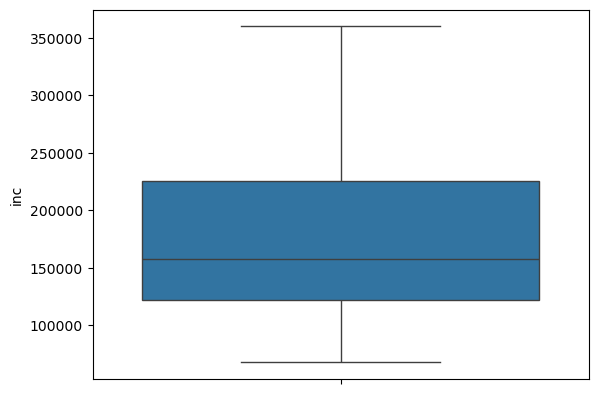

In [747]:
#Kiểm tra sau khi xử lý outlier
sns.boxplot(data['inc'])
plt.show()

In [748]:
# Tìm Optimal Binning
optb = OptimalBinning(name="inc_bin")

optb.fit(data['inc'], data['df_flag'])

binning_table = optb.binning_table

print(binning_table.build())

                           Bin  Count  Count (%)  Non-event  Event  \
0            (-inf, 109125.00)   5627   0.154346       5569     58   
1       [109125.00, 137025.00)   8846   0.242642       8786     60   
2       [137025.00, 161550.00)   4097   0.112379       4075     22   
3       [161550.00, 303750.00)  14074   0.386044      13954    120   
4             [303750.00, inf)   3813   0.104589       3771     42   
5                      Special      0   0.000000          0      0   
6                      Missing      0   0.000000          0      0   
Totals                          36457   1.000000      36155    302   

        Event rate       WoE        IV        JS  
0         0.010307 -0.220616  0.008388  0.001046  
1         0.006783  0.201427  0.008930  0.001114  
2         0.005370   0.43644  0.017397  0.002158  
3         0.008526 -0.029114  0.000332  0.000041  
4         0.011015 -0.287718  0.010004  0.001246  
5         0.000000       0.0  0.000000  0.000000  
6         0.

In [749]:
# Binning

bin_inc = [0, 109125.00, 137025.00, 161550.00, 303750.00, max(data['inc'])]
data= get_category(data, 'inc', bin_inc, labels=None, qcut=False)


In [750]:
# Tính toán iv
iv, iv_gp_inc = calc_iv(data, 'gp_inc', 'df_flag')
ivtable_numerical.loc[ivtable_numerical['variable']=='inc','IV'] = iv
iv_gp_inc

This variable IV is:  0.04505178648358216
(161550.0, 303750.0]    14074
(109125.0, 137025.0]     8846
(0.0, 109125.0]          5627
(137025.0, 161550.0]     4097
(303750.0, 360000.0]     3813
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,gp_inc,"(0.0, 109125.0]",5627,5569,58,0.154346,0.010307,0.154031,0.192053,-0.220616,0.008388
1,gp_inc,"(109125.0, 137025.0]",8846,8786,60,0.242642,0.006783,0.243009,0.198675,0.201427,0.008930
2,gp_inc,"(137025.0, 161550.0]",4097,4075,22,0.112379,0.005370,0.112709,0.072848,0.436440,0.017397
3,gp_inc,"(161550.0, 303750.0]",14074,13954,120,0.386044,0.008526,0.385949,0.397351,-0.029114,0.000332
4,gp_inc,"(303750.0, 360000.0]",3813,3771,42,0.104589,0.011015,0.104301,0.139073,-0.287718,0.010004


famsize

In [751]:
#Kiểm tra missing
data['famsize'].isna().sum()

0

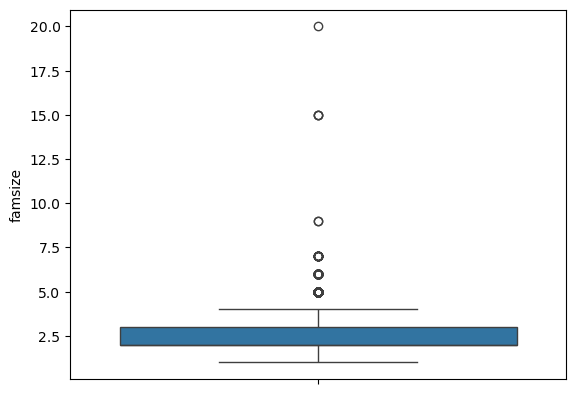

In [752]:
#Kiểm tra giá trị outlier
sns.boxplot(data['famsize'])
plt.show()

In [753]:
# Xử lý giá trị outlier
data['famsize'] = mstats.winsorize(data['famsize'], limits=[0.025, 0.025])

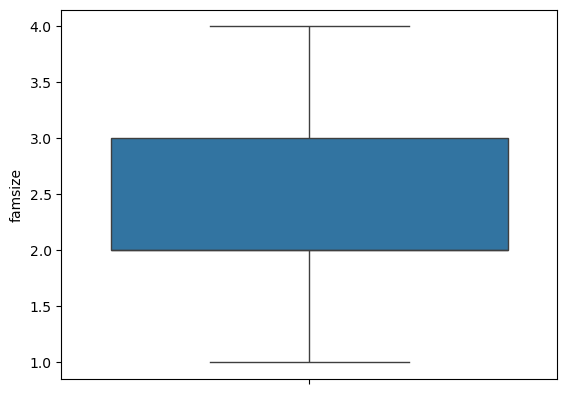

In [754]:
#Kiểm tra giá trị outlier
sns.boxplot(data['famsize'])
plt.show()

In [755]:
# Tìm Optimal Binning
optb = OptimalBinning(name="famsize_bin")

optb.fit(data['famsize'], data['df_flag'])

binning_table = optb.binning_table

print(binning_table.build())

# => các bin được chia không có ý nghĩa về khoảng cách => Giữ nguyên original value

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 1.50)   6987   0.191650       6914     73    0.010448   
1       [1.50, 2.50)  19463   0.533862      19306    157    0.008067   
2       [2.50, 3.50)   6421   0.176125       6374     47    0.007320   
3        [3.50, inf)   3586   0.098362       3561     25    0.006972   
4            Special      0   0.000000          0      0    0.000000   
5            Missing      0   0.000000          0      0    0.000000   
Totals                36457   1.000000      36155    302    0.008284   

             WoE        IV        JS  
0      -0.234299  0.011830  0.001475  
1       0.026782  0.000378  0.000047  
2       0.124691  0.002577  0.000322  
3       0.173777  0.002730  0.000341  
4            0.0  0.000000  0.000000  
5            0.0  0.000000  0.000000  
Totals            0.017515  0.002185  


In [756]:
# Tính toán iv
iv, iv_famsize = calc_iv(data, 'famsize', 'df_flag')
ivtable_numerical.loc[ivtable_numerical['variable']=='famsize','IV'] = iv
iv_famsize

This variable IV is:  0.017514899801181316
2.0    19463
1.0     6987
3.0     6421
4.0     3586
Name: famsize, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,famsize,1.0,6987,6914,73,0.191650,0.010448,0.191232,0.241722,-0.234299,0.011830
1,famsize,2.0,19463,19306,157,0.533862,0.008067,0.533979,0.519868,0.026782,0.000378
2,famsize,3.0,6421,6374,47,0.176125,0.007320,0.176297,0.155629,0.124691,0.002577
3,famsize,4.0,3586,3561,25,0.098362,0.006972,0.098493,0.082781,0.173777,0.002730


wkTime

In [757]:
#Kiểm tra missing
data['wkTime'].isna().sum()

0

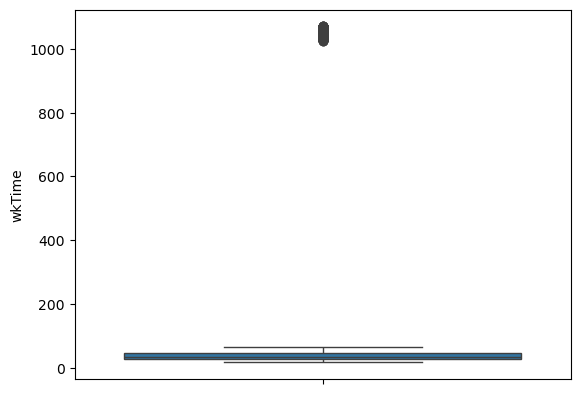

In [758]:
#Kiểm tra giá trị outlier
sns.boxplot(data['wkTime'])
plt.show()

In [759]:
# Xử lý giá trị outlier
data['wkTime'] = mstats.winsorize(data['wkTime'], limits=[0.025, 0.2])

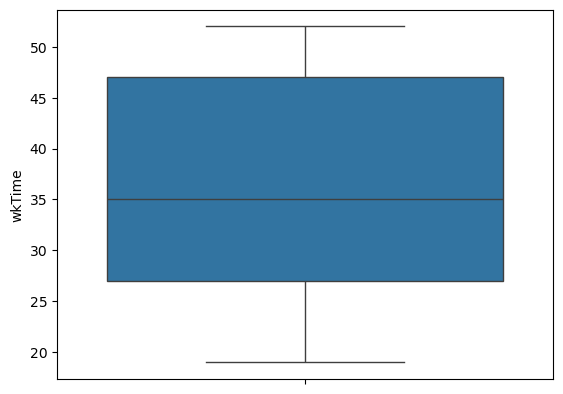

In [760]:
#Kiểm tra giá trị outlier
sns.boxplot(data['wkTime'])
plt.show()

In [761]:
# Tìm Optimal Binning
optb = OptimalBinning(name="wkTime")

optb.fit(data['wkTime'], data['df_flag'])

binning_table = optb.binning_table

print(binning_table.build())

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 31.50)  14659   0.402090      14550    109    0.007436   
1       [31.50, 33.50)   2130   0.058425       2125      5    0.002347   
2       [33.50, 35.50)   1929   0.052912       1920      9    0.004666   
3       [35.50, 42.50)   5863   0.160820       5807     56    0.009551   
4         [42.50, inf)  11876   0.325754      11753    123    0.010357   
5              Special      0   0.000000          0      0    0.000000   
6              Missing      0   0.000000          0      0    0.000000   
Totals                  36457   1.000000      36155    302    0.008284   

             WoE        IV        JS  
0       0.108855  0.004518  0.000564  
1       1.266946  0.053488  0.006272  
2       0.577712  0.013463  0.001660  
3      -0.143676  0.003566  0.000445  
4      -0.225464  0.018536  0.002312  
5            0.0  0.000000  0.000000  
6            0.0  0.000000  0.000000  
Totals            0.0

In [762]:
# Binning
bin_inc = [0, 31.5, 33.5, 35.5, 42.5, max(data['wkTime'])]
data= get_category(data, 'wkTime', bin_inc, labels=None, qcut=False)

In [763]:
# Tính toán iv
iv, iv_gp_wkTime = calc_iv(data, 'gp_wkTime', 'df_flag')
ivtable_numerical.loc[ivtable_numerical['variable']=='wkTime','IV'] = iv
iv_gp_wkTime

This variable IV is:  0.09357072661573311
(0.0, 31.5]     14659
(42.5, 52.0]    11876
(35.5, 42.5]     5863
(31.5, 33.5]     2130
(33.5, 35.5]     1929
Name: gp_wkTime, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WOE,IV
0,gp_wkTime,"(0.0, 31.5]",14659,14550,109,0.402090,0.007436,0.402434,0.360927,0.108855,0.004518
1,gp_wkTime,"(31.5, 33.5]",2130,2125,5,0.058425,0.002347,0.058775,0.016556,1.266946,0.053488
2,gp_wkTime,"(33.5, 35.5]",1929,1920,9,0.052912,0.004666,0.053105,0.029801,0.577712,0.013463
3,gp_wkTime,"(35.5, 42.5]",5863,5807,56,0.160820,0.009551,0.160614,0.185430,-0.143676,0.003566
4,gp_wkTime,"(42.5, 52.0]",11876,11753,123,0.325754,0.010357,0.325073,0.407285,-0.225464,0.018536


In [764]:
# Tổng hợp IV
ivtable_numerical

,variable,IV
0,chldNo,0.002878
1,inc,0.045052
2,famsize,0.017515
3,wkTime,0.093571


In [765]:
useful_numerical_lst = ['gp_inc', 'gp_wkTime']
useful_numerical_lst

['gp_inc', 'gp_wkTime']

In [766]:
useful_categorical_lst

['reality', 'inctp', 'edutp', 'famtp', 'houtp', 'occtp']

3.4. Feature transformation

In [783]:
woe_data = data[['reality', 'inctp', 'edutp', 'famtp', 'houtp', 'occtp', 'gp_inc', 'gp_wkTime','df_flag']]

woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0


In [784]:
woe_gp_inc = pd.DataFrame(iv_gp_inc[['Value', 'WOE']])
woe_gp_inc = woe_gp_inc.rename(columns={'WOE': 'woe_gp_inc'})
woe_data = pd.merge(woe_data, woe_gp_inc, how='left', left_on='gp_inc', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718


In [785]:
woe_gp_wkTime = pd.DataFrame(iv_gp_wkTime[['Value', 'WOE']])
woe_gp_wkTime = woe_gp_wkTime.rename(columns={'WOE': 'woe_gp_wkTime'})
woe_data = pd.merge(woe_data, woe_gp_wkTime, how='left', left_on='gp_wkTime', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855


In [786]:
woe_reality = pd.DataFrame(iv_reality[['Value', 'WOE']])
woe_reality = woe_reality.rename(columns={'WOE': 'woe_reality'})
woe_data = pd.merge(woe_data, woe_reality, how='left', left_on='reality', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201


In [794]:
woe_inctp = pd.DataFrame(iv_inctp[['Value', 'WOE']])
woe_inctp = woe_inctp.rename(columns={'WOE': 'woe_inctp'})
woe_data = pd.merge(woe_data, woe_inctp, how='left', left_on='inctp', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality,woe_edutp,woe_famtp,woe_houtp,woe_occtp,woe_inctp
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945,-0.054454,0.190788
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945,-0.054454,0.190788


In [787]:
woe_edutp = pd.DataFrame(iv_edutp[['Value', 'WOE']])
woe_edutp = woe_edutp.rename(columns={'WOE': 'woe_edutp'})
woe_data = pd.merge(woe_data, woe_edutp, how='left', left_on='edutp', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality,woe_edutp
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624


In [788]:
woe_famtp = pd.DataFrame(iv_famtp[['Value', 'WOE']])
woe_famtp = woe_famtp.rename(columns={'WOE': 'woe_famtp'})
woe_data = pd.merge(woe_data, woe_famtp, how='left', left_on='famtp', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality,woe_edutp,woe_famtp
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559


In [789]:
woe_houtp = pd.DataFrame(iv_houtp[['Value', 'WOE']])
woe_houtp = woe_houtp.rename(columns={'WOE': 'woe_houtp'})
woe_data = pd.merge(woe_data, woe_houtp, how='left', left_on='houtp', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality,woe_edutp,woe_famtp,woe_houtp
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945


In [790]:
woe_occtp = pd.DataFrame(iv_occtp[['Value', 'WOE']])
woe_occtp = woe_occtp.rename(columns={'WOE': 'woe_occtp'})
woe_data = pd.merge(woe_data, woe_occtp, how='left', left_on='occtp', right_on='Value')
woe_data = woe_data.drop(columns='Value')
woe_data.head(2)

,reality,inctp,edutp,famtp,houtp,occtp,gp_inc,gp_wkTime,df_flag,woe_gp_inc,woe_gp_wkTime,woe_reality,woe_edutp,woe_famtp,woe_houtp,woe_occtp
0,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945,-0.054454
1,Y,Working,Higher education,Civil marriage,Rented apartment,NULL,"(303750.0, 360000.0]","(0.0, 31.5]",0.0,-0.287718,0.108855,0.121201,-0.108624,1.120559,-0.048945,-0.054454


In [796]:
sample_data = woe_data[['woe_reality', 'woe_inctp', 'woe_edutp', 'woe_famtp', 'woe_houtp', 'woe_occtp', 'woe_gp_inc', 'woe_gp_wkTime']]
sample_data.head(2)

,woe_reality,woe_inctp,woe_edutp,woe_famtp,woe_houtp,woe_occtp,woe_gp_inc,woe_gp_wkTime
0,0.121201,0.190788,-0.108624,1.120559,-0.048945,-0.054454,-0.287718,0.108855
1,0.121201,0.190788,-0.108624,1.120559,-0.048945,-0.054454,-0.287718,0.108855


3.4. Correlation

<AxesSubplot:>

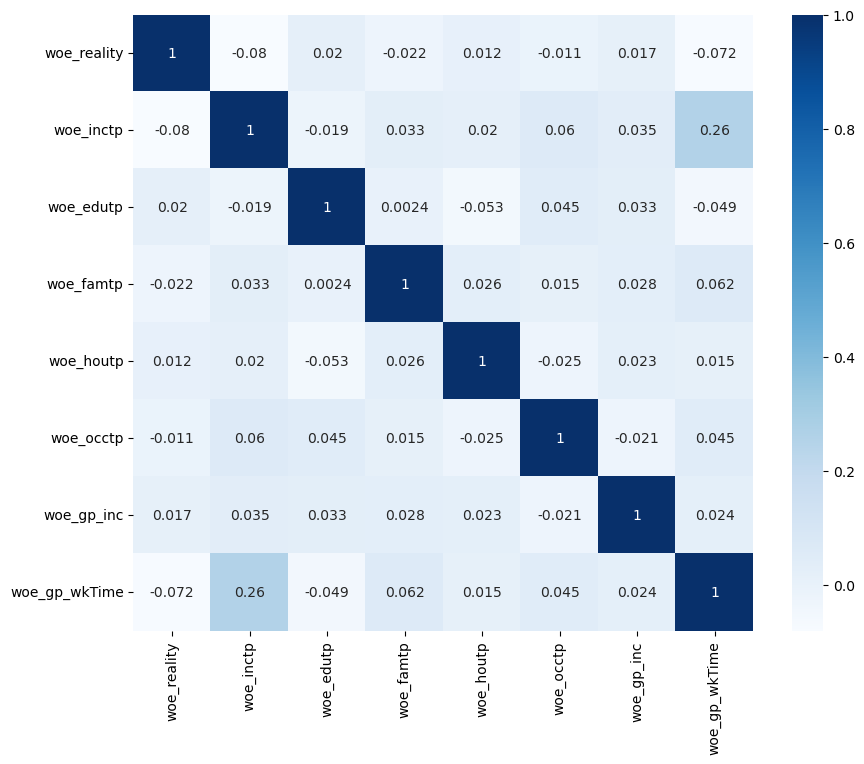

In [799]:
plt.figure(figsize = (10,8))

corr = sample_data.corr()
sns.heatmap(corr,
            xticklabels= corr.columns,
            yticklabels= corr.columns,
            annot = True, cmap = plt.cm.Blues)


IV. Train Test split

In [801]:
Y = woe_data['df_flag']
Y.shape

(36457,)

In [805]:
X = sample_data
X.shape

(36457, 8)

In [806]:
X.head(2)

,woe_reality,woe_inctp,woe_edutp,woe_famtp,woe_houtp,woe_occtp,woe_gp_inc,woe_gp_wkTime
0,0.121201,0.190788,-0.108624,1.120559,-0.048945,-0.054454,-0.287718,0.108855
1,0.121201,0.190788,-0.108624,1.120559,-0.048945,-0.054454,-0.287718,0.108855


In [813]:
x_train, x_test,y_train , y_test = train_test_split(X, Y, test_size=0.2)

In [814]:
x_train.shape

(29165, 8)

In [815]:
y_train.shape

(29165,)

V. Train model

Train model with Logistic Regression class

In [810]:
from Logistic_Regression_class import SLR

In [811]:
lgr = SLR(learning_rate=1e-2, n_epochs=1000, cutoff=0.5)

In [817]:
# model = lgr.fit(x_train, y_train)

Train model with Logistic regression in Python lib

In [820]:
lgr2 = LogisticRegression(penalty='l1', random_state= 42, solver='liblinear')

In [825]:
model2 = lgr2.fit(x_train, y_train)
model2.intercept_
model2.coef_

array([[-1.16227853, -0.53023876, -0.85742943, -0.85582162, -0.85480261,
        -0.81975969, -0.75423637, -1.01974177]])

In [827]:
y_pred_model2 = model2.predict(x_test)

In [829]:
accuracy_model2 = accuracy_score(y_test, y_pred_model2)
print('Accuracy_score: ', accuracy_model2)

Accuracy_score:  0.9917718047174986


In [833]:
print(classification_report(y_test, y_pred_model2))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7232
         1.0       0.00      0.00      0.00        60

    accuracy                           0.99      7292
   macro avg       0.50      0.50      0.50      7292
weighted avg       0.98      0.99      0.99      7292



V. Hyperparameter Tunning

In [835]:
param_grid = {
    'penalty': ['l1', 'l2'],  # 'l1' for L1 regularization, 'l2' for L2 regularization
    'random_state': [42, 88],  # List of random_state values
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Solver options
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

In [836]:
lr_tunning = LogisticRegression()

In [837]:
gridsearch = GridSearchCV(lr_tunning, param_grid, cv=5, scoring='accuracy')
gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'random_state': [42, 88],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='accuracy')

In [838]:
best_param = gridsearch.best_params_

In [841]:
best_model = LogisticRegression(**best_param)
best_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [842]:
y_pred_best_model = best_model.predict(x_test)

In [844]:
accuracy_best_model = accuracy_score(y_test,y_pred_best_model)
print('Accuracy: ',accuracy_best_model )

Accuracy:  0.9917718047174986


In [845]:
print(classification_report(y_test, y_pred_best_model))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      7232
         1.0       0.00      0.00      0.00        60

    accuracy                           0.99      7292
   macro avg       0.50      0.50      0.50      7292
weighted avg       0.98      0.99      0.99      7292



VII. Save model and its parameters

In [847]:
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)